In [165]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','nature'])
import os

# us_ret.feather 불러오기
us_ret = pd.read_feather('./RIPT_processed_data/us_ret.feather')

# Train 이후 데이터만 사용
TRAIN = '2009-01-01'
us_ret = us_ret[us_ret['Date'] >= TRAIN]

# 종목별 수익률을 수익률 벡터로 변환
us_ret = us_ret.pivot(index='Date', columns='StockID', values='Ret')

# 수익률이 없는 날은 0으로 채움
us_ret.fillna(0, inplace=True)
us_ret.to_feather('./RIPT_processed_data/us_ret_TRAIN.feather')

In [98]:
import os
import pandas as pd

def load_ensemble_results(folder_path):
    """
    폴더 내의 모든 앙상블 결과 파일을 로드하고 하나의 데이터프레임으로 병합합니다.
    
    Args:
        folder_path (str): 앙상블 결과 파일이 있는 폴더 경로
    
    Returns:
        pd.DataFrame: 병합된 앙상블 결과 데이터프레임
    """
    all_data = []
    for file in os.listdir(folder_path):
        if file.endswith('.csv') and 'ensem' in file:
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path)
            
            df['ending_date'] = pd.to_datetime(df['ending_date'])
            df['StockID'] = df['StockID'].astype(str)
            df.set_index(['ending_date', 'StockID'], inplace=True)
            
            all_data.append(df)
    
    if not all_data:
        raise ValueError(f"No CSV files found in {folder_path}")
    
    combined_df = pd.concat(all_data)
    combined_df.sort_index(inplace=True)
    
    # unnamed 컬럼 제거
    combined_df = combined_df.loc[:, ~combined_df.columns.str.contains('^Unnamed')]
    
    # MarketCap 컬럼 제거
    if 'MarketCap' in combined_df.columns:
        combined_df.drop('MarketCap', axis=1, inplace=True)
    
    return combined_df

def process_ensemble_results(base_folder):
    """
    모든 모델과 윈도우 사이즈에 대해 앙상블 결과를 처리합니다.
    
    Args:
        base_folder (str): 기본 폴더 경로
    """
    models = ['CNN', 'TS']
    window_sizes = [5, 20, 60]
    
    for model in models:
        for w in window_sizes:
            folder_path = os.path.join(base_folder, f'{model}{w}', f'{w}D20P', 'ensem_res')
            output_path = f'./RIPT_WORK_SPACE/ensemble_{model}{w}_res.feather'
            
            print(f'Processing Ensemble {model}{w}...   ', end='')
            try:
                ensemble_results = load_ensemble_results(folder_path)
                ensemble_results.to_feather(output_path)
                print(f'Shape of the dataframe: {ensemble_results.shape}')
            except Exception as e:
                print(f'Error processing {model}{w}: {str(e)}')

# 메인 실행 코드
if __name__ == "__main__":
    base_folder = 'RIPT_WORK_SPACE/new_model_res/'
    process_ensemble_results(base_folder)

Processing Ensemble CNN5...   Shape of the dataframe: (353076, 2)
Processing Ensemble CNN20...   Shape of the dataframe: (353510, 2)
Processing Ensemble CNN60...   Shape of the dataframe: (353535, 2)
Processing Ensemble TS5...   Shape of the dataframe: (351716, 2)
Processing Ensemble TS20...   Shape of the dataframe: (351715, 2)
Processing Ensemble TS60...   Shape of the dataframe: (351712, 2)


In [129]:
def load_and_process_ensemble_results(file_path, n_stocks=50):
    """
    앙상블 결과를 로드하고 처리하여 각 날짜별 상위 N개 주식을 선택합니다.
    
    Args:
        file_path (str): 앙상블 결과 파일 경로
        n_stocks (int): 선택할 상위 주식의 수
    
    Returns:
        pd.DataFrame: 각 날짜별 상위 N개 주식의 정보
    """
    # 앙상블 결과 로드
    ensemble_results = pd.read_feather(file_path)
    
    # Long format으로 변환 및 정렬
    ensemble_results_long = (ensemble_results
                             .pivot_table(index='ending_date', columns='StockID', values='up_prob')
                             .reset_index()
                             .melt(id_vars=['ending_date'], var_name='StockID', value_name='up_prob')
                             .sort_values(['ending_date', 'up_prob'], ascending=[True, False]))
    
    # 각 날짜별 상위 N개 주식 선택
    top_stocks = ensemble_results_long.groupby('ending_date').head(n_stocks)
    top_stocks.reset_index(drop=True, inplace=True)
    
    return top_stocks

file_path = './RIPT_WORK_SPACE/ensemble_CNN20_res.feather'
top_stocks = load_and_process_ensemble_results(file_path, n_stocks=50)

print(top_stocks.head())
print(f"\nShape of the dataframe: {top_stocks.shape}")
print(f"Number of unique dates: {top_stocks['ending_date'].nunique()}")
print(f"Number of unique stocks: {top_stocks['StockID'].nunique()}")

  ending_date StockID   up_prob
0  2001-01-31    5618  0.833693
1  2001-01-31    4598  0.819150
2  2001-01-31    2663  0.818620
3  2001-01-31    4930  0.817075
4  2001-01-31    3854  0.811253

Shape of the dataframe: (9700, 3)
Number of unique dates: 194
Number of unique stocks: 1791


In [163]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize

# Assuming us_ret and top_stocks are loaded as before

# Function to select top stocks for each rebalance date
def select_top_stocks(top_stocks, rebalance_dates, n):
    selected_stocks = []
    for date in rebalance_dates:
        selected = top_stocks[top_stocks['ending_date'] == date].head(n)['StockID'].values
        selected_stocks.append((date, selected))
    return selected_stocks

# Filter top_stocks to include only data after TRAIN date
top_stocks = top_stocks[top_stocks['ending_date'] >= TRAIN]

# Get unique rebalance dates
rebalance_dates = top_stocks['ending_date'].unique()

# Select top N stocks for each rebalance date
N_TOP_STOCKS = 50  # Number of top stocks to select
selected_stocks_list = select_top_stocks(top_stocks, rebalance_dates, N_TOP_STOCKS)

# Portfolio optimization function
def portfolio_optimization(returns):
    n = returns.shape[1]
    mean_returns = returns.mean()
    cov_matrix = returns.cov()
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0, 1) for _ in range(n))

    def portfolio_variance(weights):
        return weights.T @ cov_matrix @ weights

    initial_weights = np.array(n * [1. / n])

    optimized = minimize(portfolio_variance, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)

    if optimized.success:
        return optimized.x
    else:
        raise BaseException('Optimization failed')

# Dictionary to store portfolio weights for each period
portfolio_weights = {}

# Iterate over each rebalance period
for i, (rebalance_date, stock_ids) in enumerate(selected_stocks_list):
    # For avoiding look-ahead bias, use data up to the rebalance date
    end_date = rebalance_date
    if i > 0:
        start_date = selected_stocks_list[i - 1][0]  # Previous rebalance date
    else:
        start_date = us_ret.index.min()  # Or a defined start date

    # Extract returns for the optimization period
    period_returns = us_ret.loc[start_date:end_date, stock_ids]

    # Handle missing data
    period_returns = period_returns.dropna(axis=0, how='any')

    if period_returns.shape[0] < 2:
        print(f"Not enough data to optimize for period ending on {end_date}")
        continue

    # Perform portfolio optimization
    try:
        weights = portfolio_optimization(period_returns)
        portfolio_weights[rebalance_date] = pd.Series(weights, index=stock_ids)
        print(f"Optimized portfolio for period starting on {rebalance_date}")
    except Exception as e:
        print(f"Optimization failed for period starting on {rebalance_date}: {e}")

# Display the portfolio weights
portfolio_weights_df = pd.DataFrame(portfolio_weights)
print(portfolio_weights_df)


Optimized portfolio for period starting on 2009-03-31 00:00:00
Optimized portfolio for period starting on 2009-04-30 00:00:00
Optimized portfolio for period starting on 2009-06-30 00:00:00
Optimized portfolio for period starting on 2009-07-31 00:00:00
Optimized portfolio for period starting on 2009-08-31 00:00:00
Optimized portfolio for period starting on 2009-09-30 00:00:00
Optimized portfolio for period starting on 2009-11-30 00:00:00
Optimized portfolio for period starting on 2009-12-31 00:00:00
Optimized portfolio for period starting on 2010-03-31 00:00:00
Optimized portfolio for period starting on 2010-04-30 00:00:00
Optimized portfolio for period starting on 2010-06-30 00:00:00
Optimized portfolio for period starting on 2010-08-31 00:00:00
Optimized portfolio for period starting on 2010-09-30 00:00:00
Optimized portfolio for period starting on 2010-11-30 00:00:00
Optimized portfolio for period starting on 2010-12-31 00:00:00
Optimized portfolio for period starting on 2011-01-31 0

/tmp/ipykernel_1063071/2364858782.py:20: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  portfolio_returns = portfolio_returns._append(daily_portfolio_returns)


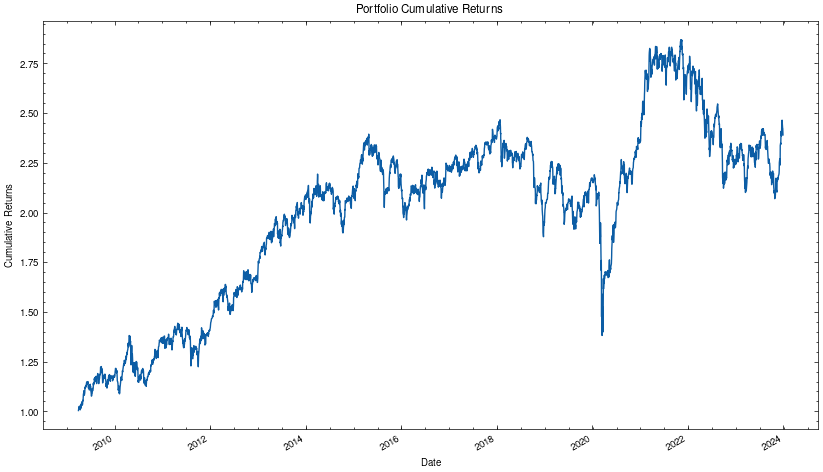

In [164]:
# Initialize a DataFrame to store portfolio returns
portfolio_returns = pd.Series(dtype=float)

# Iterate over each period to calculate portfolio returns
for i, (rebalance_date, weights_series) in enumerate(portfolio_weights.items()):
    # Get the start and end dates for the investment period
    start_date = rebalance_date
    if i < len(portfolio_weights) - 1:
        end_date = list(portfolio_weights.keys())[i + 1]
    else:
        end_date = us_ret.index.max()

    # Get the returns for the period
    period_returns = us_ret.loc[start_date:end_date, weights_series.index]

    # Calculate daily portfolio returns
    daily_portfolio_returns = period_returns.dot(weights_series)

    # Append to the portfolio_returns series
    portfolio_returns = portfolio_returns._append(daily_portfolio_returns)

# Calculate cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod()

# Plot cumulative returns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
cumulative_returns.plot()
plt.title('Portfolio Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.show()


In [53]:
def load_ensemble_results(folder_path):
    """폴더 내의 모든 앙상블 결과 파일을 로드하고 하나의 데이터프레임으로 병합합니다."""
    all_data = []
    for file in os.listdir(folder_path):
        if file.endswith('.csv'):
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path)
            df['Date'] = pd.to_datetime(df['ending_date'])
            df['StockID'] = df['StockID'].astype(str)
            df.set_index(['Date', 'StockID'], inplace=True)
            df.drop('ending_date', axis=1, inplace=True)
            all_data.append(df)
    
    combined_df = pd.concat(all_data)
    combined_df.sort_index(inplace=True)
    return combined_df

def select_top_stocks(df, date, top_n):
    """특정 날짜에 대해 상승 확률이 높은 상위 N개 주식을 선택합니다."""
    date_df = df.loc[date].sort_values('up_prob', ascending=False)
    return date_df.head(top_n)

def select_bottom_stocks(df, date, bottom_n):
    """특정 날짜에 대해 상승 확률이 낮은 하위 N개 주식을 선택합니다."""
    date_df = df.loc[date].sort_values('up_prob', ascending=True)
    return date_df.head(bottom_n)

# 메인 실행 코드
folder_path = 'RIPT_WORK_SPACE/new_model_res/CNN2D/60D20P/ensem_res/'
ensemble_results = load_ensemble_results(folder_path)

# 2018년 이후의 데이터만 선택
start_date = pd.Timestamp('2018-01-01')
ensemble_results = ensemble_results[ensemble_results.index.get_level_values('Date') >= start_date]

strategies = {
    'Top 50 (Equal Weight)': (50, 'equal_weight', 'top'),
    'Top 100 (Equal Weight)': (100, 'equal_weight', 'top'),
    'Top N/5 (Equal Weight)': (len(ensemble_results.index.get_level_values('StockID').unique()) // 5, 'equal_weight', 'top'),
    'Top N/2 (Equal Weight)': (len(ensemble_results.index.get_level_values('StockID').unique()) // 2, 'equal_weight', 'top'),
    'Top 50 (Min Variance)': (50, 'min_variance', 'top'),
    'Top 50 (Max Sharpe)': (50, 'max_sharpe', 'top'),

    'Bottom 50 (Equal Weight)': (50, 'equal_weight', 'bottom'),
    'Bottom 100 (Equal Weight)': (100, 'equal_weight', 'bottom'),
    'Bottom N/5 (Equal Weight)': (len(ensemble_results.index.get_level_values('StockID').unique()) // 5, 'equal_weight', 'bottom'),
    'Bottom N/2 (Equal Weight)': (len(ensemble_results.index.get_level_values('StockID').unique()) // 2, 'equal_weight', 'bottom'),
}

results = {}
for name, (n, opt_type, select_type) in strategies.items():
    print(f"Running backtest for {name}...")
    portfolio_returns, portfolio_weights = backtest(ensemble_results, n, opt_type, select_type)
    cumulative_returns = (1 + portfolio_returns).cumprod()
    results[name] = cumulative_returns

Running backtest for Top 50 (Equal Weight)...
Running backtest for Top 100 (Equal Weight)...
Running backtest for Top N/5 (Equal Weight)...
Running backtest for Top N/2 (Equal Weight)...
Running backtest for Top 50 (Min Variance)...


Exception: Invalid dimensions for arguments.

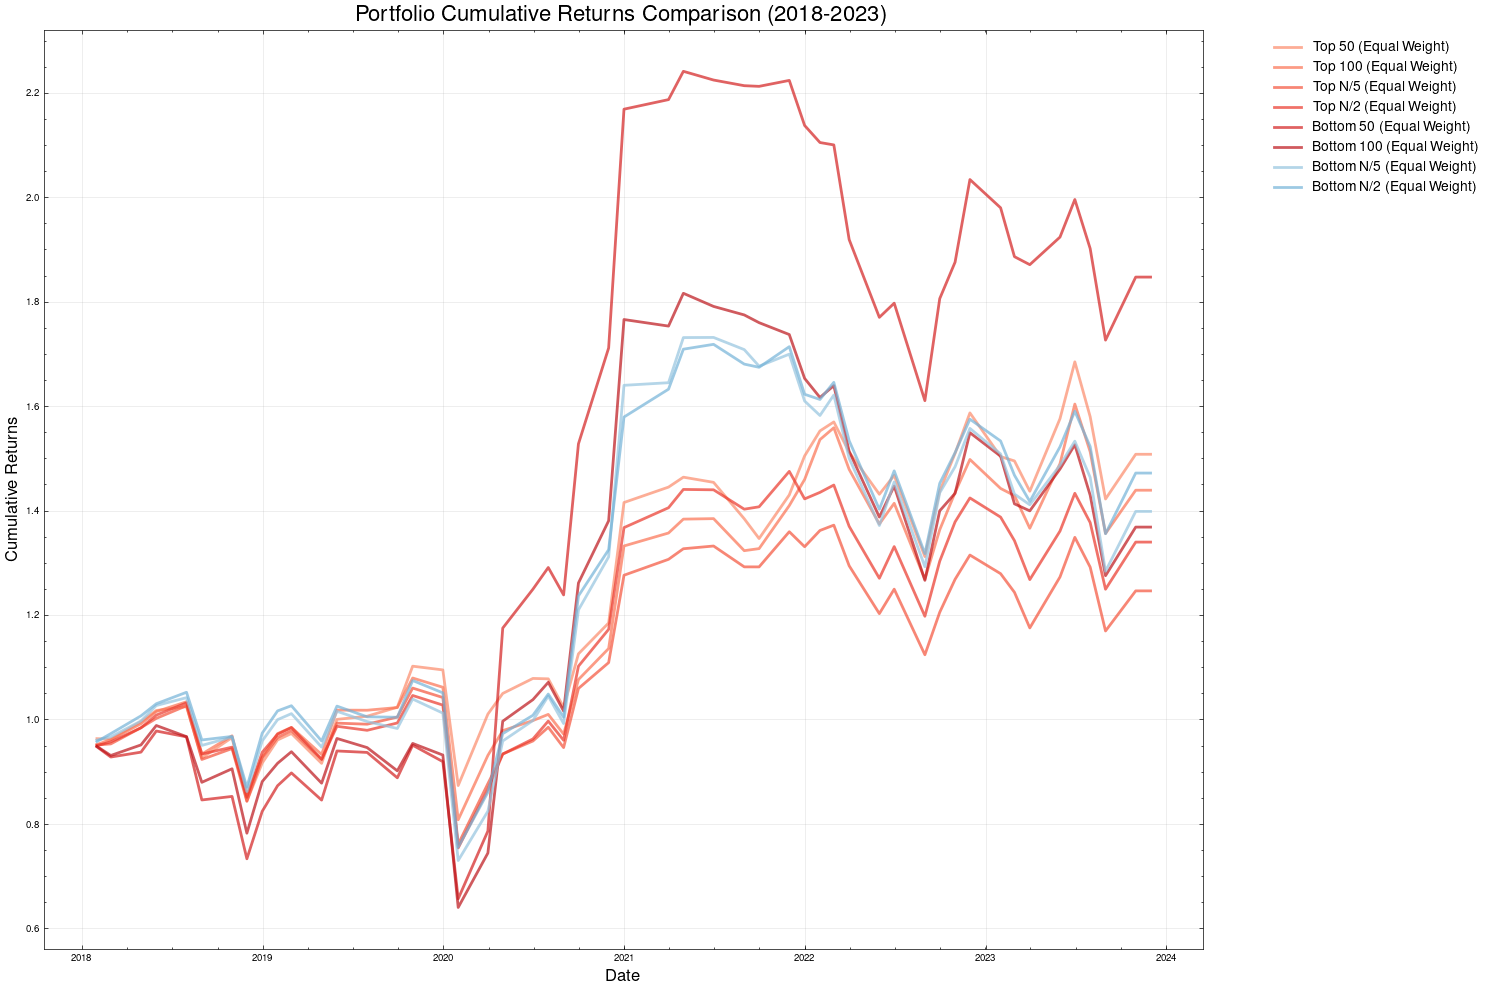


Performance Metrics (2018-2023):
--------------------------------------------------------------------------------
Strategy                          Total Return     Ann. Return Ann. Volatility    Sharpe Ratio
--------------------------------------------------------------------------------
Top 50 (Equal Weight)                   50.77%           7.30%         113.13%            0.06
Top 100 (Equal Weight)                  43.89%           6.44%         113.17%            0.06
Top N/5 (Equal Weight)                  24.62%           3.85%         113.81%            0.03
Top N/2 (Equal Weight)                  33.96%           5.14%         116.47%            0.04
Bottom 50 (Equal Weight)                84.70%          11.10%         182.33%            0.06
Bottom 100 (Equal Weight)               36.83%           5.53%         165.70%            0.03
Bottom N/5 (Equal Weight)               39.83%           5.92%         138.64%            0.04
Bottom N/2 (Equal Weight)               47.1

In [52]:
# 누적 수익률 비교 그래프
plt.figure(figsize=(15, 10))

colors = plt.cm.Reds(np.linspace(0.4, 0.8, 6))  # Top 전략을 위한 붉은 계열 색상
colors = np.vstack((colors, plt.cm.Blues(np.linspace(0.4, 0.8, 6))))  # Bottom 전략을 위한 파란 계열 색상 추가

for (name, cumulative_returns), color in zip(results.items(), colors):
    if 'Top' in name:
        plt.plot(cumulative_returns.index, cumulative_returns.values, label=name, color=color, linewidth=2, alpha=0.7)
    else:
        plt.plot(cumulative_returns.index, cumulative_returns.values, label=name, color=color, linewidth=2, alpha=0.7)

plt.title('Portfolio Cumulative Returns Comparison (2018-2023)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Returns', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

# 성과 지표 계산 및 출력
print("\nPerformance Metrics (2018-2023):")
print("-" * 80)
print(f"{'Strategy':<30} {'Total Return':>15} {'Ann. Return':>15} {'Ann. Volatility':>15} {'Sharpe Ratio':>15}")
print("-" * 80)

for name, cumulative_returns in results.items():
    portfolio_returns = cumulative_returns.pct_change().dropna()
    total_return = cumulative_returns.iloc[-1] - 1
    years = (cumulative_returns.index[-1] - cumulative_returns.index[0]).days / 365.25
    annualized_return = (1 + total_return) ** (1 / years) - 1
    annualized_volatility = portfolio_returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility
    
    print(f"{name:<30} {total_return:15.2%} {annualized_return:15.2%} {annualized_volatility:15.2%} {sharpe_ratio:15.2f}")

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skfolio import RiskMeasure, RatioMeasure
from skfolio.optimization import MeanRisk, EqualWeighted, InverseVolatility, Random
from skfolio.preprocessing import prices_to_returns
from skfolio.moments import EmpiricalCovariance, EmpiricalMu
from skfolio.prior import EmpiricalPrior

# 데이터 로드 및 전처리
folder_path = 'RIPT_WORK_SPACE/new_model_res/CNN2D/60D20P/ensem_res/'
ensemble_results = load_ensemble_results(folder_path)

# 2018년 이후의 데이터만 선택
start_date = pd.Timestamp('2018-01-01')
ensemble_results = ensemble_results[ensemble_results.index.get_level_values('Date') >= start_date]

# 수익률 데이터 준비
returns = ensemble_results['ret_val'].unstack()

# 전략 정의
strategies = {
    'Equal Weighted': EqualWeighted(),
    'Inverse Volatility': InverseVolatility(),
    'Random Portfolio': Random(),
    'Minimum Variance': MeanRisk(
        risk_measure=RiskMeasure.VARIANCE,
        prior_estimator=EmpiricalPrior(
            mu_estimator=EmpiricalMu(),
            covariance_estimator=EmpiricalCovariance()
        )
    ),
    'Maximum Sharpe Ratio': MeanRisk(
        objective_function="sharpe_ratio",
        risk_measure=RiskMeasure.VARIANCE,
        prior_estimator=EmpiricalPrior(
            mu_estimator=EmpiricalMu(),
            covariance_estimator=EmpiricalCovariance()
        )
    )
}

# 백테스트 함수
def backtest(returns, model):
    portfolio_returns = []
    for i in range(len(returns) - 1):
        train_returns = returns.iloc[:i+1]
        test_returns = returns.iloc[i+1]
        
        model.fit(train_returns)
        weights = model.weights_
        
        portfolio_return = np.sum(test_returns * weights)
        portfolio_returns.append(portfolio_return)
    
    return pd.Series(portfolio_returns, index=returns.index[1:])

# 백테스트 실행
results = {}
for name, model in strategies.items():
    print(f"Running backtest for {name}...")
    portfolio_returns = backtest(returns, model)
    results[name] = (1 + portfolio_returns).cumprod()

# 결과 시각화
plt.figure(figsize=(15, 10))
colors = plt.cm.rainbow(np.linspace(0, 1, len(results)))

for (name, cumulative_returns), color in zip(results.items(), colors):
    plt.plot(cumulative_returns.index, cumulative_returns.values, label=name, color=color, linewidth=2, alpha=0.7)

plt.title('Portfolio Cumulative Returns Comparison (2018-2023)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Cumulative Returns', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

# 성과 지표 계산 및 출력
print("\nPerformance Metrics (2018-2023):")
print("-" * 80)
print(f"{'Strategy':<20} {'Total Return':>15} {'Ann. Return':>15} {'Ann. Volatility':>15} {'Sharpe Ratio':>15}")
print("-" * 80)

for name, cumulative_returns in results.items():
    portfolio_returns = cumulative_returns.pct_change().dropna()
    total_return = cumulative_returns.iloc[-1] - 1
    years = (cumulative_returns.index[-1] - cumulative_returns.index[0]).days / 365.25
    annualized_return = (1 + total_return) ** (1 / years) - 1
    annualized_volatility = portfolio_returns.std() * np.sqrt(252)
    sharpe_ratio = annualized_return / annualized_volatility
    
    print(f"{name:<20} {total_return:15.2%} {annualized_return:15.2%} {annualized_volatility:15.2%} {sharpe_ratio:15.2f}")

Running backtest for Equal Weighted...
Running backtest for Inverse Volatility...


/home/indi/anaconda3/envs/imagedpo2/lib/python3.11/site-packages/skfolio/moments/covariance/_empirical_covariance.py:98: RuntimeWarning: Degrees of freedom <= 0 for slice
  covariance = np.cov(X.T, ddof=self.ddof)
/home/indi/anaconda3/envs/imagedpo2/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/indi/anaconda3/envs/imagedpo2/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


ValueError: The matrix must be symmetric

In [33]:
returns

StockID,0,1,1001,1002,1012,1014,1019,1020,1021,1023,...,942,946,959,962,975,978,981,99,996,998
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-31,-0.066704,-0.134569,-0.101545,-0.210570,-0.152447,-0.039041,-0.006140,-0.046534,0.057936,-0.062387,...,-0.050051,-0.027097,-0.132818,-0.017212,-0.042517,0.007451,-0.125583,-0.068109,0.001130,-0.039958
2018-02-28,-0.043135,0.133765,-0.060897,0.093428,-0.065723,-0.096068,0.046096,0.051044,0.012718,0.049974,...,0.067638,0.053410,-0.073825,-0.006274,-0.000332,0.024701,-0.001589,0.022508,-0.003879,0.022601
2018-04-30,-0.055944,-0.062075,0.137643,-0.003295,0.029046,-0.023089,0.031476,0.067478,0.103358,0.013226,...,0.011341,0.056531,-0.061725,-0.005853,0.080731,-0.029963,-0.004146,0.099865,0.024002,0.001459
2018-05-31,0.066061,-0.099906,-0.010873,-0.055852,-0.151208,0.078757,0.010174,0.086252,0.048478,-0.016988,...,0.046880,0.106450,0.070147,-0.001688,-0.014427,-0.111286,-0.057857,0.038236,0.045370,0.029409
2018-07-31,0.023958,0.031864,-0.023927,-0.257116,0.001623,-0.008393,-0.005645,0.189122,0.111516,0.056579,...,0.005039,0.057822,-0.116213,0.002626,0.012340,-0.085111,-0.047682,0.087867,0.024990,0.037733
2018-08-31,-0.040947,-0.215054,-0.270062,-0.219620,-0.313385,-0.080455,-0.113896,-0.071288,-0.084067,-0.175029,...,-0.083382,0.016428,-0.102473,-0.113316,-0.128142,0.100427,-0.096732,-0.015390,-0.007873,-0.072999
2018-10-31,0.117195,-0.091767,-0.064996,0.130472,0.277263,-0.011475,0.020793,-0.035809,-0.075454,0.075075,...,0.045014,0.042462,-0.194215,0.094115,0.028085,0.020437,0.003242,0.024260,0.038392,0.086758
2018-11-30,-0.068737,-0.163200,-0.163404,-0.207028,-0.158521,-0.197393,-0.129696,-0.065920,-0.126446,-0.150405,...,-0.155637,-0.062614,-0.085760,-0.257765,-0.141457,0.148443,-0.121908,-0.109379,-0.091155,-0.141987
2018-12-31,0.128357,0.116581,0.314919,0.285794,0.321637,0.239424,0.126481,0.042559,0.160646,0.117222,...,0.107372,0.079735,0.107708,0.198876,0.009643,-0.035218,0.176049,0.065382,0.081660,0.168392
